# Фаза 2 • Неделя 9 • Понедельник
## Компьютерное зрение • Computer Vision
### Автоэнкодер 

В задании необходимо обучить автоэнкодер для очискти изображений документов от шумов. 

Ссылка на соревнование на `kaggle`: https://www.kaggle.com/c/denoising-dirty-documents/data

1. Импортируй библиотеки для создания нейросети и визуализации изображений. 

In [1]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms as T
from torchvision.utils import save_image
from torchsummary import summary

import os
from torchvision import transforms as T
from torchvision.io import read_image

device = torch.device('cpu')

In [2]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder 
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4),
            nn.BatchNorm2d(256),
            # nn.Dropout(),
            nn.SELU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=2),
            nn.BatchNorm2d(128),
            # nn.Dropout(),
            nn.SELU()
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.SELU()
            )
        
        self.pool = nn.MaxPool2d(2, 2, return_indices=True) #<<<<<< Bottleneck
        
        #decoder
        # Как работает Conv2dTranspose https://github.com/vdumoulin/conv_arithmetic

        self.unpool = nn.MaxUnpool2d(2, 2)
        
        self.conv0_t = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.SELU()
            )
        self.conv1_t = nn.Sequential(
            nn.ConvTranspose2d(128, 256, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.SELU()
            )
        self.conv2_t = nn.Sequential(
            nn.ConvTranspose2d(256, 1, kernel_size=4, padding=0),
            nn.LazyBatchNorm2d(),
            nn.Sigmoid()
            )        

    def encode(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x, indicies = self.pool(x) # ⟸ bottleneck
        return x, indicies

    def decode(self, x, indicies):
        x = self.unpool(x, indicies)
        x = self.conv0_t(x)
        x = self.conv1_t(x)
        x = self.conv2_t(x)
        return x

    def forward(self, x):
        latent, indicies = self.encode(x)
        out = self.decode(latent, indicies)      

        return out


model = ConvAutoencoder().to(device)

model.load_state_dict(torch.load('autoencoder_model_weights.pt'))

/home/alex/projects/ds_online/.ds/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

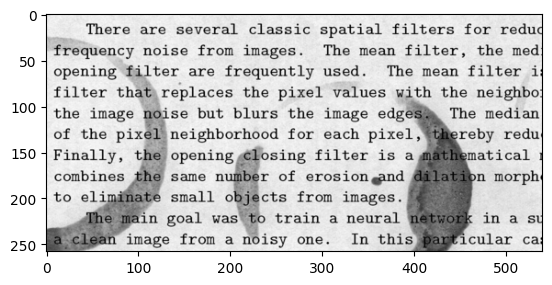

In [3]:
img = io.read_image('63.png').detach()
plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')

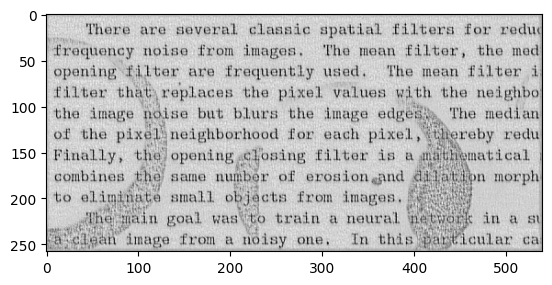

In [4]:
model.eval()
img2 = model(img.unsqueeze(0)/255).data.squeeze(0).squeeze(0)
plt.imshow(img2, cmap='gray')